In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
## CSV file created from the nsys report txt file. The file is a stat report from the profiling. 

# Load your CSV file (adjust path if needed)
df = pd.read_csv("API_calls.csv")

# Sort by Total Time descending
df_sorted = df.sort_values(by="Total Time (ns)", ascending=False)

# Plot top 10 kernels by Total Time
top_n = 10

plt.figure(figsize=(12, 6))
plt.barh(df_sorted['Name'][:top_n], df_sorted['Total Time (ns)'][:top_n], color='skyblue')
plt.xlabel('Total Time (ns)')
plt.title('Top 10 Kernels by Total Time')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('top_api.png', dpi=300)  # or 'top_kernels.pdf'
plt.show()

# Pie chart of Time(%) distribution for top 10 kernels
plt.figure(figsize=(8, 8))
plt.pie(df_sorted['Time (per)'][:top_n], labels=df_sorted['Name'][:top_n], autopct='%1.1f%%', startangle=140)
plt.title('Time (%) Distribution for Top 10 Kernels')
plt.tight_layout()
plt.savefig('Time_api.png', dpi=300)  # or 'top_kernels.pdf'
plt.show()


In [ ]:
### Mapping of process number in llm trace to api calls name in mytrace sqlite

import sqlite3

# Path to your exported .sqlite file
db_path = "my_trace.sqlite"  # <- Replace this with your actual file

# List of string IDs you want to map
string_ids = [i for i in range(1, 700)]  # Adjust the range as needed

# Connect to SQLite database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Try to find the correct table name
possible_tables = ["StringIds"]
found_table = None
for table in possible_tables:
    try:
        cursor.execute(f"SELECT COUNT(*) FROM {table}")
        found_table = table
        break
    except:
        continue

if not found_table:
    print("❌ No suitable StringTable found in the database.")
    conn.close()
    exit()

# Fetch string mappings
query = f"""
SELECT id, value
FROM {found_table}
WHERE id IN ({','.join(['?']*len(string_ids))})
"""
cursor.execute(query, string_ids)
results = cursor.fetchall()
print(results)
# Display mapping
print(f"\n✅ String ID to String Mapping from `{found_table}`:\n")
for id_, value in sorted(results):
    print(f"{id_:>4} → {value}")

conn.close()




[(1, 'SocMetrics'), (2, 'mm_'), (3, 'task_submit'), (4, 'class_id'), (5, 'syncpt_id'), (6, 'syncpt_thresh'), (7, 'pid'), (8, 'tid'), (9, 'GenericCounters'), (10, 'FTrace'), (11, 'ETW'), (12, 'Chunk Allocation'), (13, 'TLS allocation'), (14, 'NVTX profiling started'), (15, '[NSys]'), (16, '[NSys Comms]'), (17, 'dlopen(libToolsInjectionProxy64.so)'), (18, 'cuDNN profiling initialization'), (19, 'dlopen(math.cpython-312-aarch64-linux-gnu.so)'), (20, 'dlopen(_opcode.cpython-312-aarch64-linux-gnu.so)'), (21, 'dlopen(_json.cpython-312-aarch64-linux-gnu.so)'), (22, 'dlopen(_struct.cpython-312-aarch64-linux-gnu.so)'), (23, 'dlopen(_heapq.cpython-312-aarch64-linux-gnu.so)'), (24, 'dlopen(_queue.cpython-312-aarch64-linux-gnu.so)'), (25, 'dlopen(_datetime.cpython-312-aarch64-linux-gnu.so)'), (26, 'dlopen(_socket.cpython-312-aarch64-linux-gnu.so)'), (27, 'dlopen(select.cpython-312-aarch64-linux-gnu.so)'), (28, 'dlopen(array.cpython-312-aarch64-linux-gnu.so)'), (29, 'dlopen(binascii.cpython-312-aar

In [34]:
### Replace process number in json file llm trace with api calls name

import json

annotated_events = []

with open("llm_trace.json", "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        event = json.loads(line)
        
        args = event.get("args", {})
        string_id = args.get("StringId")
        if string_id is not None and string_id in results:
            args["StringName"] = results[string_id]
        
        if isinstance(event.get("name"), int):
            sid = event["name"]
            if sid in results:
                event["name"] = results[sid]
        
        annotated_events.append(event)

# Save annotated events as a JSON array
with open("nsys_trace_annotated.json", "w") as f:
    json.dump(annotated_events, f, indent=2)

print("✅ Annotated JSON lines saved as a JSON array in 'nsys_trace_annotated.json'")

✅ Annotated JSON lines saved as a JSON array in 'nsys_trace_annotated.json'


In [50]:
#CREATE a csv file with API calls and their total time. Only cuda events are considered

# Path to your file
file_path = "llm_trace.json"

# Lists to store parsed data
cuda_events = []

# Read file line by line
with open(file_path, "r") as f:
    for line in f:
        try:
            entry = json.loads(line)
            if entry.get("Type") == 79 and "CudaEvent" in entry:
                cuda = entry["CudaEvent"]
                start = int(cuda.get("startNs", 0))
                end = int(cuda.get("endNs", 0))
                duration = end - start
                name = cuda.get("kernel", {}).get("demangledName", "Unnamed")
                name = results[int(name)][1]
                stream_id = cuda.get("streamId", "unknown")
                correlation_id = cuda.get("correlationId", "n/a")

                cuda_events.append({
                    "name": name,
                    "startNs": start,
                    "endNs": end,
                    "durationNs": duration,
                    "streamId": stream_id,
                    "correlationId": correlation_id
                })
        except json.JSONDecodeError:
            continue  # skip malformed lines

# Convert to DataFrame
df = pd.DataFrame(cuda_events)

# Preview
print(df.head())
print(len(df), "CUDA events found.")

# Save to CSV (optional)
df.to_csv("cuda_events_timeline.csv", index=False)


                                                name     startNs       endNs  \
0                      vectorized_elementwise_kernel  7296179783  7296181607   
1  _ZN2at6native29vectorized_elementwise_kernelIL...  7319909489  7319911345   
2  _ZN2at6native44_GLOBAL__N__50c743a2_11_Indexin...  7337689866  7337691594   
3  _ZN2at6native13reduce_kernelILi512ELi1ENS0_8Re...  7338627271  7338628391   
4  _ZN2at6native13reduce_kernelILi512ELi1ENS0_8Re...  7338753479  7338754535   

   durationNs streamId  correlationId  
0        1824        7           1640  
1        1856        7           1674  
2        1728        7           1820  
3        1120        7           1914  
4        1056        7           1945  
7376 CUDA events found.


/var/folders/kl/jggjwjfd6b53jyqdbzqmr3gm0000gn/T/ipykernel_74110/3769974091.py:34: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



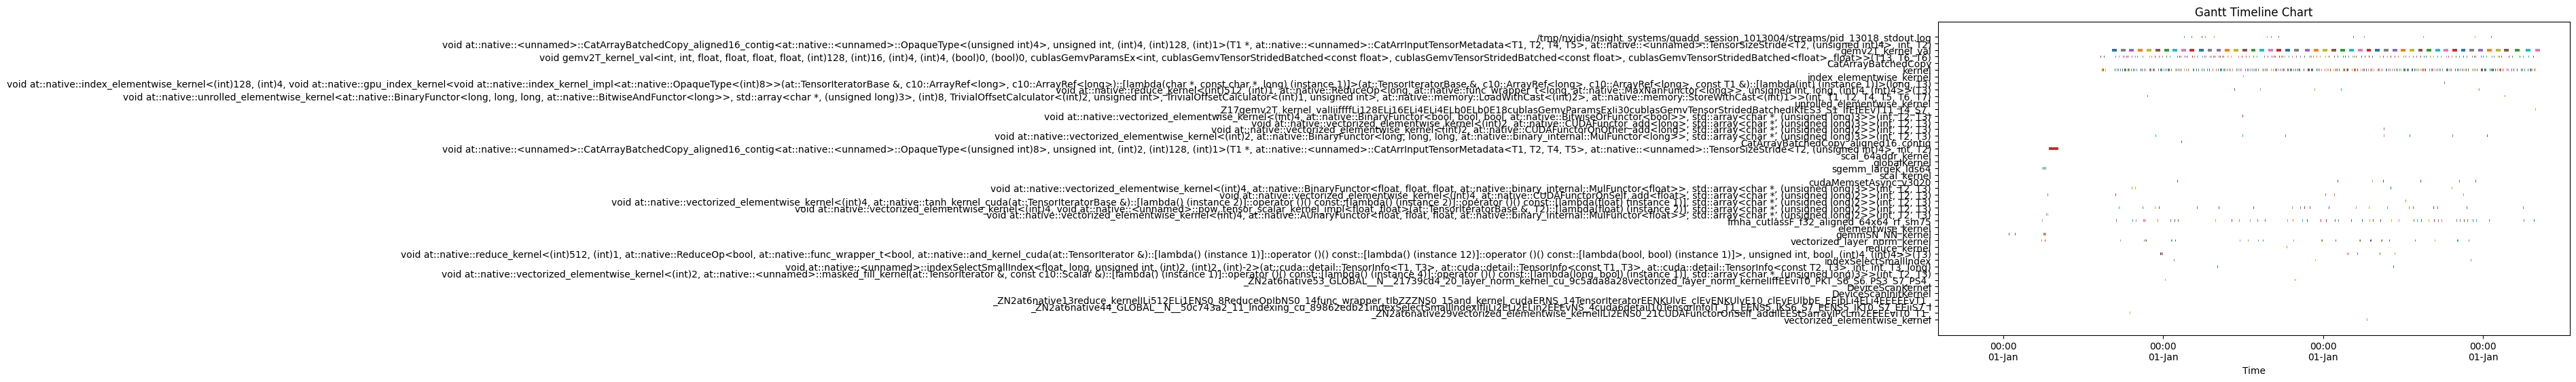

In [40]:
# Create a timeline with all individual calls in a Gantt chart
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Replace 'your_data.csv' with your actual filename
filename = 'cuda_events_timeline.csv'

# Load data
df = pd.read_csv(filename)

# Convert 'start' and 'end' columns to datetime
df['start'] = pd.to_datetime(df['start'])
df['end'] = pd.to_datetime(df['end'])

# Calculate duration in hours
df['duration'] = (df['end'] - df['start']).dt.total_seconds() / 3600

# Sort by start time (optional, for better visualization)
df = df.sort_values(by='start')

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each event as a horizontal bar
for idx, row in df.iterrows():
    ax.barh(row['name'], row['duration'], left=row['start'], height=0.4)

# Format x-axis to show time and date nicely
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%d-%b'))

plt.xlabel('Time')
plt.title('Gantt Timeline Chart')
plt.tight_layout()
plt.show()


In [ ]:
#Timeline with calls aggreated by name/type

#Num of unique process names
unique_names = df['name'].unique()
print("Unique names:")
print(len(unique_names))
# Goal: make sure that process with slightly different names are aggregated together

# 44 Unique names

Unique names:
44


In [47]:
# Replace all 'name' entries containing 'vectorize element' with 'vectorize element'
#df['name'] = df['name'].apply(lambda x: 'vectorized element' if 'vectorized_element' in x.lower() else x)
df['name'] = df['name'].apply(lambda x: 'reduce_kernel' if 'reduce_kernel' in x.lower() else x)
df['name'] = df['name'].apply(lambda x: 'indexSelectSmallIndex' if 'indexSelectSmallIndex' in x else x)
unique_names = df['name'].unique()
print("Unique names:")
print(len(unique_names))


Unique names:
17


In [53]:
print(df['name'].unique())


# Delete all rows where the 'name' column is exactly 'vectorize element'
df = df[df['name'] != '/tmp/nvidia/nsight_systems/quadd_session_1013004/streams/pid_13018_stdout.log']
print(df['name'].unique())

['elementwise_kernel' 'indexSelectSmallIndex' 'reduce_kernel'
 'DeviceScanInitKernel' 'DeviceScanKernel' 'vectorized_layer_norm_kernel'
 'gemmSN_NN_kernel' 'fmha_cutlassF_f32_aligned_64x64_rf_sm75'
 'cudaMemsetAsync_v3020' 'scal_kernel' 'sgemm_largek_lds64' 'globalKernel'
 'scal_64addr_kernel' 'CatArrayBatchedCopy' 'gemv2T' 'kernel']
['elementwise_kernel' 'indexSelectSmallIndex' 'reduce_kernel'
 'DeviceScanInitKernel' 'DeviceScanKernel' 'vectorized_layer_norm_kernel'
 'gemmSN_NN_kernel' 'fmha_cutlassF_f32_aligned_64x64_rf_sm75'
 'cudaMemsetAsync_v3020' 'scal_kernel' 'sgemm_largek_lds64' 'globalKernel'
 'scal_64addr_kernel' 'CatArrayBatchedCopy' 'gemv2T' 'kernel']


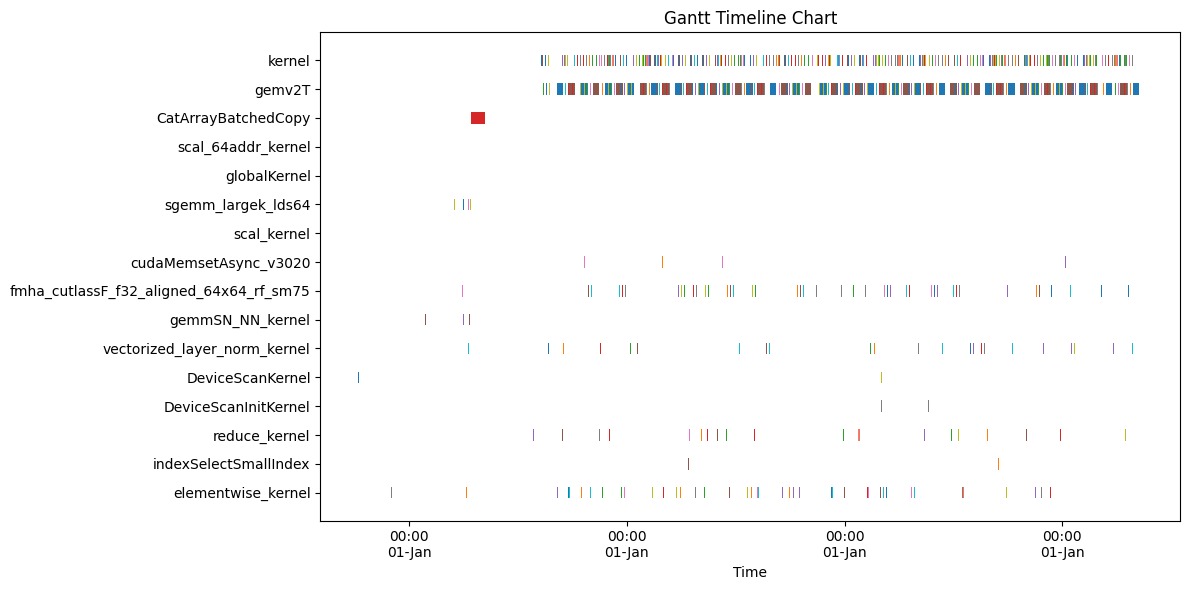

In [54]:
# Convert 'start' and 'end' columns to datetime
df['start'] = pd.to_datetime(df['start'])
df['end'] = pd.to_datetime(df['end'])

# Calculate duration in hours
df['duration'] = (df['end'] - df['start']).dt.total_seconds() / 3600

# Sort by start time (optional, for better visualization)
df = df.sort_values(by='start')

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each event as a horizontal bar
for idx, row in df.iterrows():
    ax.barh(row['name'], row['duration'], left=row['start'], height=0.4)

# Format x-axis to show time and date nicely
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%d-%b'))

plt.xlabel('Time')
plt.title('Gantt Timeline Chart')
plt.tight_layout()
plt.show()

In [55]:
df.to_csv("cuda_events_timeline.csv", index=False)

In [ ]:
## The future of AI is and just one ouput. Pretty much the same as above, but with a different technique.
# Above import sqlite file and now import import from json file.
# Alsobelow it is the data for one inferane 'The future of AI is'

In [74]:
import json
import pandas as pd
import plotly.express as px

# Load your JSON file (replace 'trace.json' with your file path)
with open('gpt2_trace.json') as f:
    data = json.load(f)

events = data.get('traceEvents', [])

# Filter events with duration (ph == 'X')
events = [e for e in events if e['ph'] == 'X']

# Extract useful info and convert timestamps (if needed)
# Timestamps seem large, so normalize to start at zero
start_ts = min(e['ts'] for e in events)

rows = []
for e in events:
    rows.append({
        'name': e.get('name', 'unknown'),
        'category': e.get('cat', 'unknown'),
        'start': e['ts'] - start_ts,
        'end': e['ts'] - start_ts + e['dur'],
        'duration': e['dur'],
        'correlation': e['args'].get('correlation') if 'args' in e else None
    })

df = pd.DataFrame(rows)
print(df)



                                name      category          start  \
0            Activity Buffer Request      overhead    1178.120117   
1                    cudaMemcpyAsync  cuda_runtime    1011.260742   
2              cudaStreamSynchronize  cuda_runtime    2571.605469   
3                    cudaMemcpyAsync  cuda_runtime    2644.761719   
4              cudaStreamSynchronize  cuda_runtime    2661.007812   
...                              ...           ...            ...   
6579  Memcpy DtoH (Device -> Pinned)    gpu_memcpy  200466.038086   
6580                 cudaMemcpyAsync  cuda_runtime  200453.682617   
6581           cudaStreamSynchronize  cuda_runtime  200466.810547   
6582           cudaDeviceSynchronize  cuda_runtime  200603.146484   
6583            PyTorch Profiler (0)         Trace       0.000000   

                end    duration  correlation  
0       2557.468117    1379.348          NaN  
1       2569.692742    1558.432      98210.0  
2       2578.965469       7.36

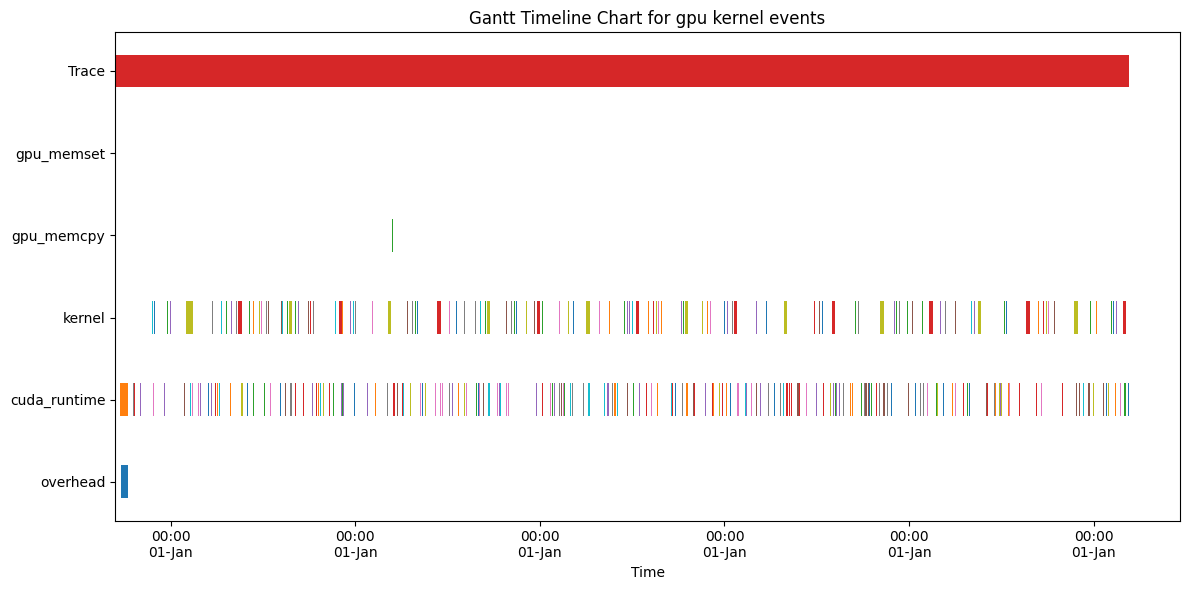

In [ ]:


# Create plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each event as a horizontal bar
for idx, row in df.iterrows():
    ax.barh(row['category'], row['duration'], left=row['start'], height=0.4)

# Format x-axis to show time and date nicely
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%d-%b'))

plt.xlabel('Time')
plt.title('Gantt Timeline Chart for gpu kernel events')
plt.tight_layout()
plt.show()


In [97]:
# Replace all 'name' entries containing 'vectorize element' with 'vectorize element'
#df['name'] = df['name'].apply(lambda x: 'vectorized element' if 'vectorized_element' in x.lower() else x)
df['name'] = df['name'].apply(lambda x: 'reduce_kernel' if 'reduce_kernel' in x.lower() else x)
df['name'] = df['name'].apply(lambda x: 'vectorized_elementwise_kernel' if 'elementwise_kernel' in x else x)
unique_names = df['name'].unique()
print("Unique names:")
print(len(unique_names))

Unique names:
28


In [98]:
print(unique_names)

['Activity Buffer Request' 'cudaMemcpyAsync' 'cudaStreamSynchronize'
 'cudaLaunchKernel' 'DeviceScanKernel' 'cudaPeekAtLastError'
 'cudaOccupancyMaxActiveBlocksPerMultiprocessorWithFlags'
 'cudaDeviceGetAttribute' 'vectorized_elementwise_kernel'
 'Memcpy DtoH (Device -> Pinned)' 'Memcpy DtoD (Device -> Device)'
 'indexSelectSmallIndex' 'reduce_kernel'
 'void at::native::(anonymous namespace)::vectorized_layer_norm_kernel<float, float>(int, float, float const*, float const*, float const*, float*, float*, float*)'
 'sgemm' 'cudaStreamIsCapturing' 'fmha_cutlass' 'Memset (Device)'
 'cudaMemsetAsync'
 'void scal_kernel<float, float, 1, true, 6, 5, 5, 3>(cublasTransposeParams<float>, float const*, float*, float const*)'
 'void cublasLt::epilogue::impl::globalKernel<8, 32, float, float, float, true, true, 1>(int, int, long, float*, cublasLtEpilogue_t, int, float*, long, void*, long, long, long, float*, long, int*)'
 'void scal_64addr_kernel<float, float, 1, true, 6, 5, 5, 3>(cublasTransposePa

/var/folders/kl/jggjwjfd6b53jyqdbzqmr3gm0000gn/T/ipykernel_74110/774532816.py:16: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



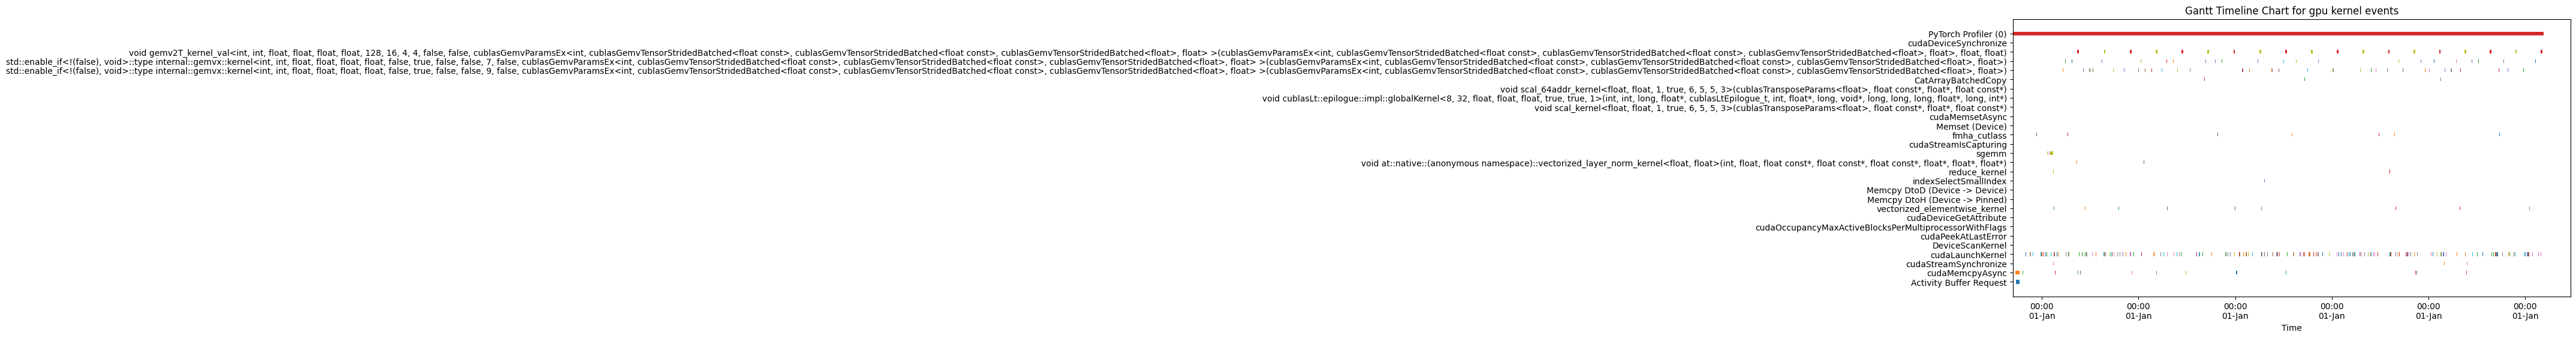

In [99]:
## The future of AI is and just one ouput

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each event as a horizontal bar
for idx, row in df.iterrows():
    ax.barh(row['name'], row['duration'], left=row['start'], height=0.4)

# Format x-axis to show time and date nicely
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%d-%b'))

plt.xlabel('Time')
plt.title('Gantt Timeline Chart for gpu kernel events')
plt.tight_layout()
plt.show()
